In [1]:
import torch
import torch.nn as nn
import albumentations as A
import numpy as np
import cv2
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import models
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import logging
from torch.utils.data import random_split
from dataclasses import dataclass
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
torch.cuda.is_available()

True

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3


In [4]:
path = Path(path)

for item in Path(path).iterdir():
    print(item)



/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals


In [5]:
animal_dir = path / "animals"
animal_dir

PosixPath('/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals')

In [6]:
animal_data = ImageFolder(animal_dir)
animal_data, animal_data.classes, animal_data.class_to_idx, animal_data.targets

(Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals,
 ['cat', 'dog'],
 {'cat': 0, 'dog': 1},
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_indices, val_indices = train_test_split(
    range(len(animal_data)), test_size=0.2, random_state=42, stratify=animal_data.targets
)
train_data_subset = Subset(animal_data, train_indices)
test_data_subset = Subset(animal_data, val_indices)
len(train_data_subset), len(test_data_subset), train_data_subset, test_data_subset

(800,
 200,
 <torch.utils.data.dataset.Subset at 0x797f217fb5b0>)

In [8]:
@dataclass
class Config:
    batch_size: int = 32
    num_workers: int = 2
    pin_memory: bool = True
    aug_prob: float = 0.5
    transforms: Optional[A.Compose] = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    image_size: Tuple[int,int] = (224,224)
    learning_rate = 1e-3
    num_classes: int = 2
    num_epochs: int = 10

config = Config()

In [9]:
def get_transforms(config: Config) -> A.Compose:
    train_transforms = A.Compose([
        A.Resize(config.image_size[0], config.image_size[1]),
        A.HorizontalFlip(p=config.aug_prob),

        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=config.aug_prob),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=20,sat_shift_limit=30,val_shift_limit=20)
        ],p=config.aug_prob),
        A.OneOf([
            A.GaussianBlur(),
            A.MotionBlur(),
            A.GaussNoise(var_limit=(10.0, 50.0))
        ],p=config.aug_prob),
        A.CoarseDropout(
            max_holes = 8,
            max_height= 12,
            max_width= 12,
            p=config.aug_prob
        ),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transforms = A.Compose([
       A.Resize(config.image_size[0], config.image_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    show_transforms = A.Compose([
        A.Resize(config.image_size[0], config.image_size[1]),
        A.HorizontalFlip(p=config.aug_prob),

        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=config.aug_prob),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=20,sat_shift_limit=30,val_shift_limit=20)
        ],p=config.aug_prob),
        A.OneOf([
            A.GaussianBlur(),
            A.MotionBlur(),
            A.GaussNoise(var_limit=(10.0, 50.0))
        ],p=config.aug_prob),
        A.CoarseDropout(
            max_holes = 4,
            max_height= 8,
            max_width= 8,
            p=config.aug_prob
        ),

        ToTensorV2()
    ])

    return{"train_transforms": train_transforms, "val_transforms": val_transforms, "show_transforms": show_transforms}



In [10]:
import random
class AnimalDataset(Dataset):
    def __init__(self, data:ImageFolder, transforms: A.Compose, config: Config):
        self.data = data
        self.transforms = transforms
        self.config = config

        self.images = self.data.samples
        self.classes = self.data.classes
        self.class_to_idx = self.data.class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx:int) -> Tuple[torch.Tensor,int]:
        img_path, label = self.images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        return img, label

    def visualize_images(self, num_images:int=5,images_per_row:int = 3,title=None,seed = None) -> None:
        n_rows = int(np.ceil(num_images/images_per_row))
        if seed is not None:
            random.seed(seed)
        fig,ax = plt.subplots(n_rows,images_per_row, figsize=(20,5 * n_rows))
        ax= ax.flatten()
        if title is not None:
            fig.suptitle(title)

        for i in range(num_images):
            rand = random.randint(0,len(self)-1)
            img, label = self[rand]
            if type(img) is torch.Tensor:
                img = img.permute(1,2,0)

            ax[i].imshow(img)
            ax[i].set_title(f"Label: {self.classes[label]}")





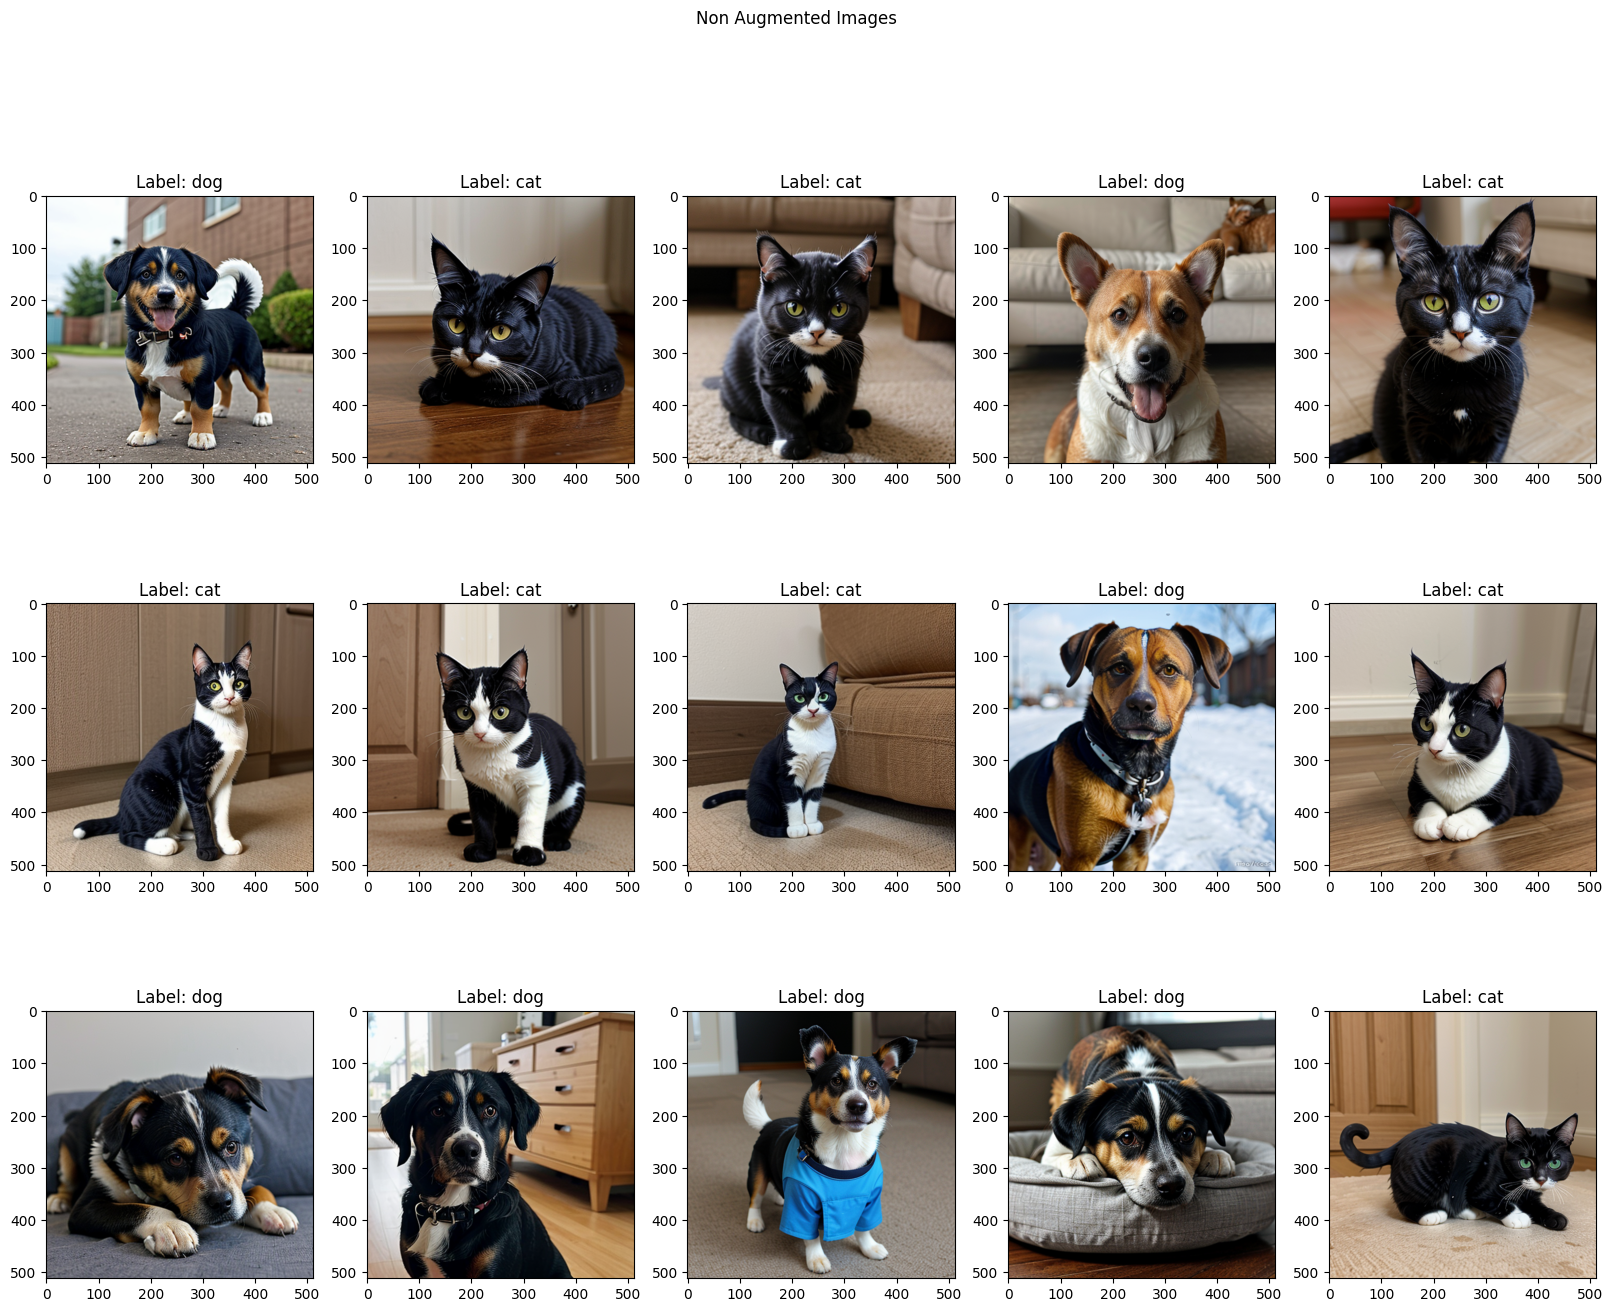

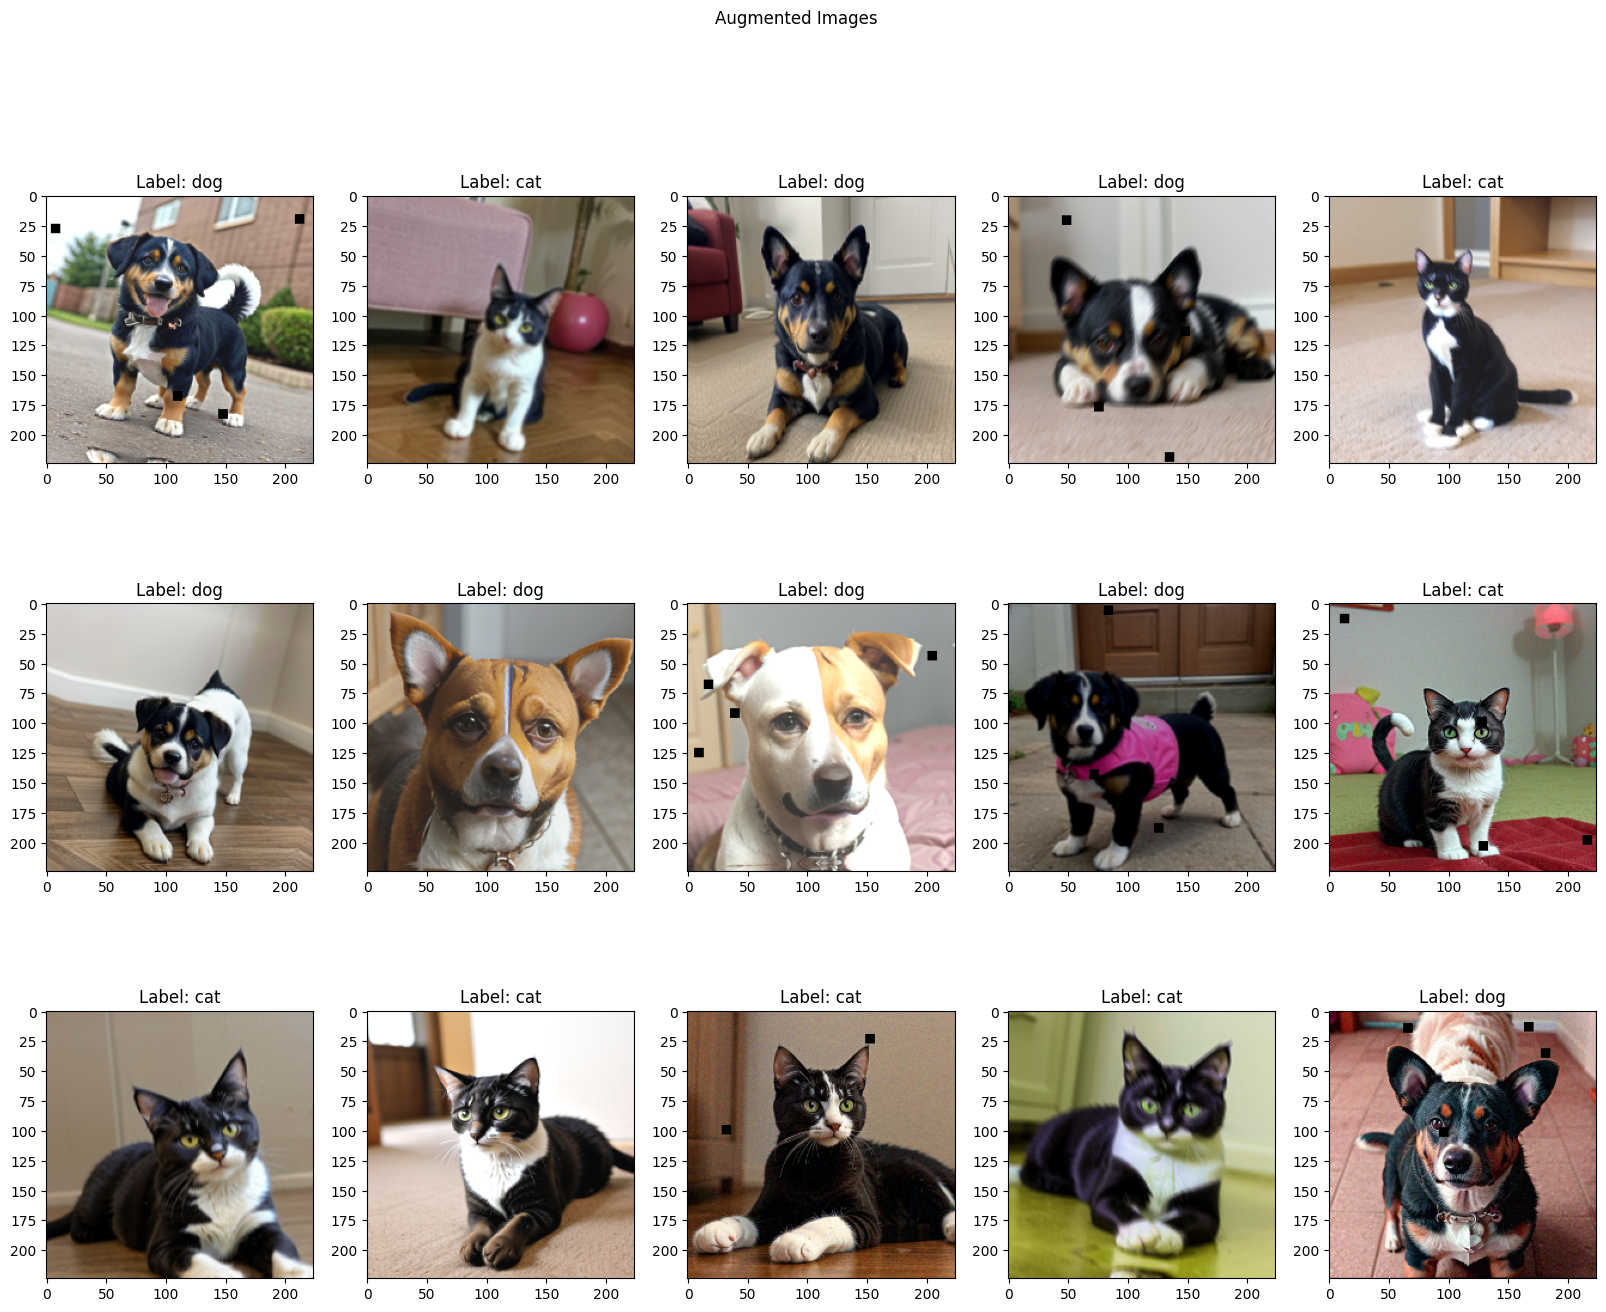

In [11]:

train_data = train_data_subset.dataset
test_data = test_data_subset.dataset


non_augmented_train_dataset = AnimalDataset(data=train_data,transforms=None,config=config)
non_augmented_train_dataset.visualize_images( num_images=15, images_per_row=5,title="Non Augmented Images",seed=42)
augmented_train_dataset = AnimalDataset(data=train_data,transforms=get_transforms(config=config)['show_transforms'],config=config)
augmented_train_dataset.visualize_images( num_images=15, images_per_row=5,title="Augmented Images",seed=42)


In [12]:

class Model(nn.Module):
    def __init__(self,num_classes:int):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet50(weights=models.ResNet50_Weights)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.model.fc.in_features,1),
        )

    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.model(x).squeeze()


In [13]:
!pip install torchmetrics

In [14]:
from torchmetrics.classification import Precision, Recall
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch.optim as optim
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.models as models

train_epoch_precisions = []
train_epoch_recall = []
val_epoch_precisions = []
val_epoch_recall = []

precision = Precision(task="binary", average="macro").to('cuda')
recall = Recall(task="binary", average="macro").to('cuda')

class EarlyStopping:
    def __init__(self, patience:int = 5, min_delta:float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss:float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val:float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str,
    scheduler = None,
    scaler: Optional[torch.cuda.amp.GradScaler] = None,
) -> Tuple[float,float]:

    precision.reset()
    recall.reset()
    model.train()
    losses = AverageMeter()
    accuracy = AverageMeter()

    pbar = tqdm(loader, desc="Training", total=len(loader))

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device).float()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.round(torch.sigmoid(outputs))
        acc = (preds == labels).float().mean()
        losses.update(loss.item(), images.size(0))
        accuracy.update(acc.item(), images.size(0))

        precision.update(preds, labels)
        recall.update(preds, labels)

        if scheduler is not None:
            scheduler.step()
        pbar.set_postfix(loss=losses.avg, accuracy=accuracy.avg)

    train_epoch_recall.append(recall.compute().item())
    train_epoch_precisions.append(precision.compute().item())

    return losses.avg, accuracy.avg

def val_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str,
) -> Tuple[float, float]:

    model.eval()
    precision.reset()
    recall.reset()
    losses = AverageMeter()
    accuracy = AverageMeter()

    pbar = tqdm(loader, desc="Validation", total=len(loader))

    with torch.inference_mode():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.round(torch.sigmoid(outputs))
            acc = (preds == labels).float().mean()
            losses.update(loss.item(), images.size(0))
            accuracy.update(acc.item(), images.size(0))

            precision.update(preds, labels)
            recall.update(preds, labels)

            pbar.set_postfix(loss=losses.avg, accuracy=accuracy.avg)

    val_epoch_recall.append(recall.compute().item())
    val_epoch_precisions.append(precision.compute().item())
    return losses.avg, accuracy.avg


def train_model(config: Config) -> Dict[str, List[float]]:
    train_indices, val_indices = train_test_split(
        range(len(animal_data)), test_size=0.2, random_state=42, stratify=animal_data.targets
    )
    train_data_subset = Subset(animal_data, train_indices)
    test_data_subset = Subset(animal_data, val_indices)

    train_data = AnimalDataset(data=train_data_subset.dataset, transforms=get_transforms(config=config)['train_transforms'], config=config)
    test_data = AnimalDataset(data=test_data_subset.dataset, transforms=get_transforms(config=config)['val_transforms'], config=config)

    train_dataset = DataLoader(
        train_data,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=True
    )

    test_dataset = DataLoader(
        test_data,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=True
    )

    model = Model(num_classes=config.num_classes).to(config.device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    scaler = torch.cuda.amp.GradScaler()

    early_stopping = EarlyStopping(patience=5, min_delta=0.0)

    epochs = config.num_epochs

    pbar = tqdm(range(epochs), desc="Epochs", total=epochs)

    for epoch in pbar:
        pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_dataset, criterion, optimizer, config.device, scheduler, scaler)
        val_loss, val_acc = val_epoch(model, test_dataset, criterion, config.device)

        pbar.set_postfix({
            "train_loss": f"{train_loss:.4f}",
            "train_acc": f"{train_acc:.4f}",
            "val_loss": f"{val_loss:.4f}",
            "val_acc": f"{val_acc:.4f}"
        })

        if early_stopping(val_loss):
            print(f"Early Stopping triggered at epoch {epoch + 1}")
            break

    return {
        "train_epoch_precisions": train_epoch_precisions,
        "train_epoch_recall": train_epoch_recall,
        "val_epoch_precisions": val_epoch_precisions,
        "val_epoch_recall": val_epoch_recall
    }


In [15]:
train_indices, val_indices = train_test_split(
    range(len(animal_data)), test_size=0.2, random_state=42, stratify=animal_data.targets
)
train_data_subset = Subset(animal_data, train_indices)
test_data_subset = Subset(animal_data, val_indices)

train_data = AnimalDataset(data=train_data_subset.dataset,transforms=get_transforms(config=config)['train_transforms'],config=config)
test_data = AnimalDataset(data=test_data_subset.dataset,transforms=get_transforms(config=config)['val_transforms'],config=config)


train_dataset = DataLoader(train_data,
                           batch_size=config.batch_size,
                           shuffle=True,
                           num_workers=config.num_workers,
                           pin_memory=config.pin_memory,
                           persistent_workers=True
                           )

test_dataset = DataLoader(test_data,
                          batch_size=config.batch_size,
                          shuffle=False,
                          num_workers=config.num_workers,
                          pin_memory=config.pin_memory,
                          persistent_workers=True
                          )

train_dataset, test_dataset

(<torch.utils.data.dataloader.DataLoader at 0x797f0c4e03d0>,
 <torch.utils.data.dataloader.DataLoader at 0x797f0c4e0430>)

In [16]:
from torch.optim.lr_scheduler import StepLR
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

def train_model(config: Config) -> Dict[str,List[float]]:
    train_indices, val_indices = train_test_split(
    range(len(animal_data)), test_size=0.2, random_state=42, stratify=animal_data.targets
)
    train_data_subset = Subset(animal_data, train_indices)
    test_data_subset = Subset(animal_data, val_indices)

    train_data = AnimalDataset(data=train_data_subset.dataset,transforms=get_transforms(config=config)['train_transforms'],config=config)
    test_data = AnimalDataset(data=test_data_subset.dataset,transforms=get_transforms(config=config)['val_transforms'],config=config)


    train_dataset = DataLoader(train_data,
                            batch_size=config.batch_size,
                            shuffle=True,
                            num_workers=config.num_workers,
                            pin_memory=config.pin_memory,
                            persistent_workers=True
                            )

    test_dataset = DataLoader(test_data,
                            batch_size=config.batch_size,
                            shuffle=False,
                            num_workers=config.num_workers,
                            pin_memory=config.pin_memory,
                            persistent_workers=True
                            )

    model = Model(num_classes=config.num_classes).to(config.device)

    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    device = config.device
    scheduler = StepLR(optimizer,step_size=5,gamma=0.1)
    scalar = torch.amp.GradScaler()

    early_stopping = EarlyStopping(patience=5,min_delta=0.0)

    epochs = config.num_epochs

    pbar = tqdm(range(epochs), desc="Epochs", total=epochs)

    for epoch in pbar:
        pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_acc = train_epoch(model,train_dataset,criterion,optimizer,device,scheduler,scalar)
        val_loss, val_acc = val_epoch(model,test_dataset,criterion,device)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        pbar.set_postfix(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

        if early_stopping(val_loss):
            print("Early Stopping")
            break

    return {
        "train_epoch_precisions": train_epoch_precisions,
        "train_epoch_recall": train_epoch_recall,
        "val_epoch_precisions": val_epoch_precisions,
        "val_epoch_recall": val_epoch_recall
    }

In [17]:
metrics = train_model(config)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Early Stopping


In [18]:
train_epoch_precisions, train_epoch_recall, val_epoch_precisions, val_epoch_recall

([0.9494163393974304,
  0.9764243364334106,
  0.9860279560089111,
  0.9900199770927429,
  0.9802371263504028,
  0.9803149700164795],
 [0.9760000109672546,
  0.9940000176429749,
  0.9879999756813049,
  0.9919999837875366,
  0.9919999837875366,
  0.9959999918937683],
 [0.9980000257492065,
  0.9960159659385681,
  0.9960159659385681,
  0.9960159659385681,
  0.9960159659385681,
  0.9960159659385681],
 [0.9980000257492065, 1.0, 1.0, 1.0, 1.0, 1.0])

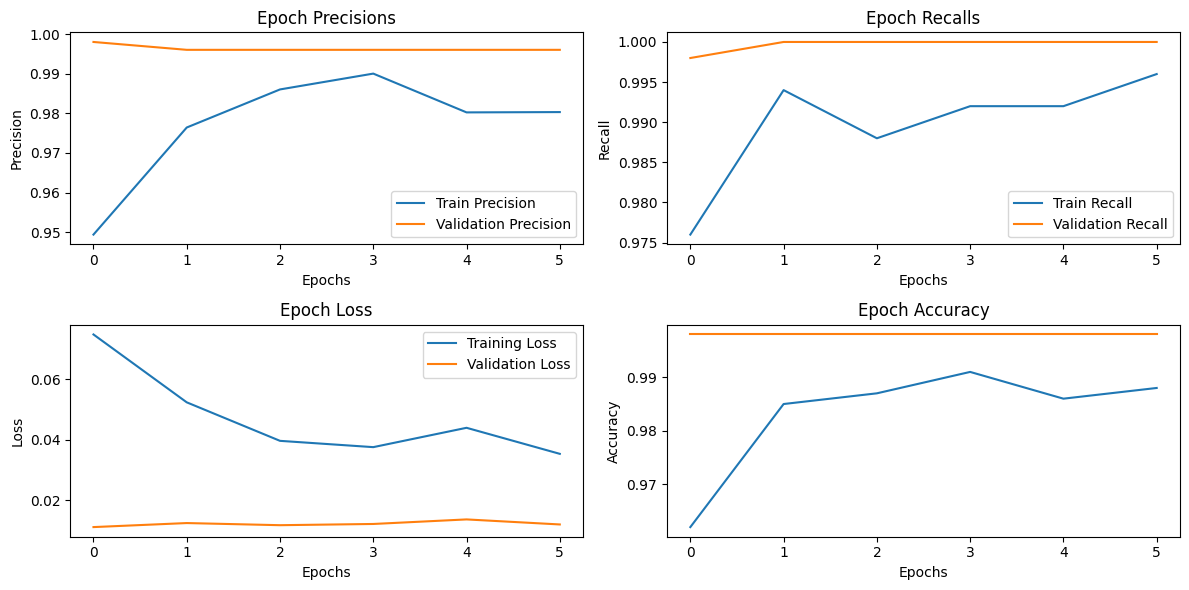

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

ax = ax.flatten()
ax[0].plot(train_epoch_precisions, label="Train Precision")
ax[0].plot(val_epoch_precisions, label="Validation Precision")
ax[0].set_title("Epoch Precisions")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Precision")
ax[0].legend()


ax[1].plot(train_epoch_recall, label="Train Recall")
ax[1].plot(val_epoch_recall, label="Validation Recall")
ax[1].set_title("Epoch Recalls")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Recall")
ax[1].legend()


ax[2].plot(train_loss_list,label="Training Loss")
ax[2].plot(val_loss_list,label="Validation Loss")
ax[2].set_title("Epoch Loss")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].legend()

ax[3].plot(train_acc_list,label="Training Accuracy")
ax[3].plot(val_acc_list,label="Validation Accuracy")
ax[3].set_title("Epoch Accuracy")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Accuracy")
plt.tight_layout()
plt.show()
